<a href="https://colab.research.google.com/github/ParthAgarwalGit/SER-using-CNNs/blob/main/AI_Club_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

def clean_audio(file_path):
    # 1. Load the audio file
    # sr=None preserves the native sampling rate, or set sr=22050 for standard
    y, sr = librosa.load(file_path, sr=22050)

    # 2. Trim the silence
    # top_db: The threshold (in decibels) below reference to consider as silence.
    # standard values are between 20 and 30.
    y_trimmed, index = librosa.effects.trim(y, top_db=20)

    return y, y_trimmed, sr

# --- Example Usage ---
import os
import glob
import kagglehub

# 1. Download the dataset
folder_path = kagglehub.dataset_download("orvile/ravdess-dataset")
print("Path to dataset folder:", folder_path)

# 2. Find all .wav files inside that folder (including subfolders like Actor_01)
# The "**/*.wav" means "look in all subdirectories for any file ending in .wav"
file_pattern = os.path.join(folder_path, "**/*.wav")
wav_files = glob.glob(file_pattern, recursive=True)

print(f"Found {len(wav_files)} audio files.")

# 3. Process the first file as a test
if wav_files:
    test_file = wav_files[0]
    original, trimmed, sample_rate = clean_audio(test_file)
    print(f"Successfully processed: {os.path.basename(test_file)}")
else:
    print("No .wav files found. Check the directory structure.")

# Verify the length difference
print(f"Original Duration: {librosa.get_duration(y=original, sr=sample_rate):.2f}s")
print(f"Trimmed Duration:  {librosa.get_duration(y=trimmed, sr=sample_rate):.2f}s")

Using Colab cache for faster access to the 'ravdess-dataset' dataset.
Path to dataset folder: /kaggle/input/ravdess-dataset
Found 2452 audio files.
Successfully processed: 03-02-05-02-01-01-02.wav
Original Duration: 4.64s
Trimmed Duration:  2.39s


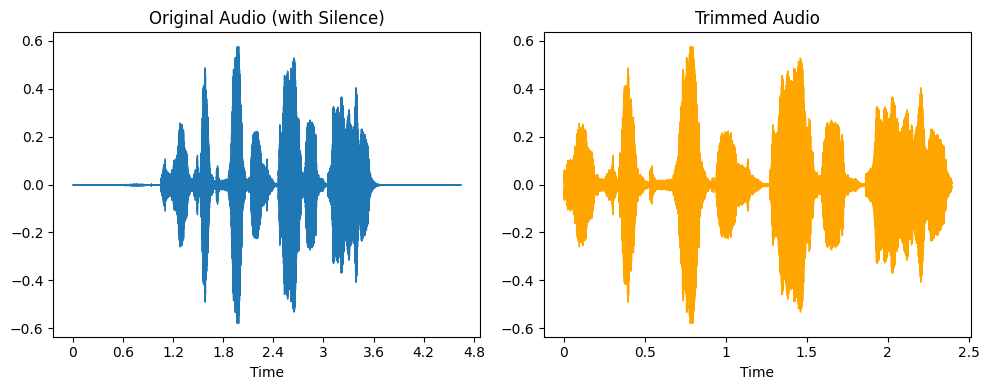

In [2]:
plt.figure(figsize=(10, 4))

# Plot Original
plt.subplot(1, 2, 1)
librosa.display.waveshow(original, sr=sample_rate)
plt.title("Original Audio (with Silence)")

# Plot Trimmed
plt.subplot(1, 2, 2)
librosa.display.waveshow(trimmed, sr=sample_rate, color='orange')
plt.title("Trimmed Audio")

plt.tight_layout()
plt.show()

Sad File Found: 03-02-04-02-01-01-02.wav
Angry File Found: 03-02-05-02-01-01-02.wav


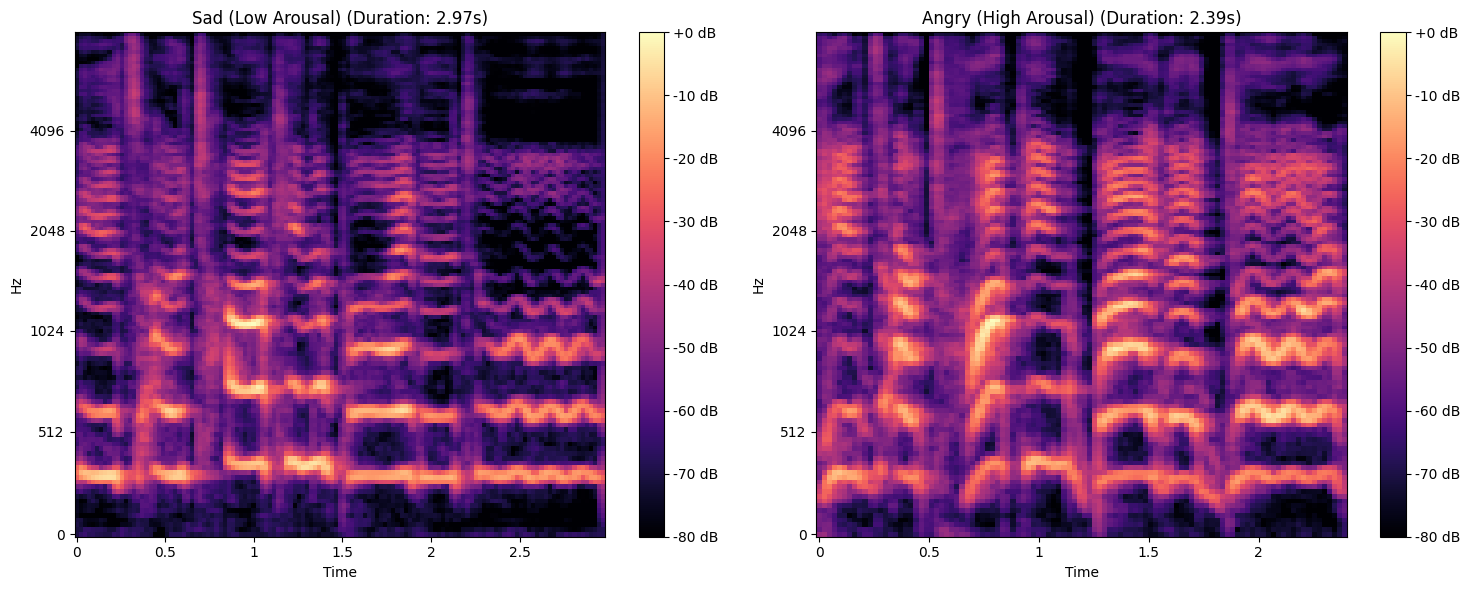

In [3]:
import librosa.display
import matplotlib.pyplot as plt

# --- 1. Helper Function to Find Specific Emotions ---
# RAVDESS Filename Convention: 03-01-XX-01-01-01-01.wav
# The 3rd part (XX) is the emotion: 04 = Sad, 05 = Angry
def get_file_by_emotion(file_list, emotion_code):
    for f in file_list:
        filename = os.path.basename(f)
        parts = filename.split("-")
        if len(parts) >= 3 and parts[2] == emotion_code:
            return f
    return None

# Find one example of each
sad_path = get_file_by_emotion(wav_files, "04")
angry_path = get_file_by_emotion(wav_files, "05")

print(f"Sad File Found: {os.path.basename(sad_path)}")
print(f"Angry File Found: {os.path.basename(angry_path)}")

# --- 2. Function to Create and Plot Spectrogram ---
def plot_comparison(sad_path, angry_path):
    plt.figure(figsize=(15, 6))

    # Helper to process one file
    def process_and_plot(path, title, subplot_index):
        # A. Load & Trim (Reuse your clean_audio logic)
        y, sr = librosa.load(path, sr=22050)
        y_trimmed, _ = librosa.effects.trim(y, top_db=20)

        # B. Convert to Mel-Spectrogram
        # n_mels=128 is standard for Deep Learning inputs
        S = librosa.feature.melspectrogram(y=y_trimmed, sr=sr, n_mels=128)

        # C. Convert to Log-Scale (dB) - Crucial for visualization!
        S_dB = librosa.power_to_db(S, ref=np.max)

        # D. Plot
        plt.subplot(1, 2, subplot_index)
        librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"{title} (Duration: {librosa.get_duration(y=y_trimmed, sr=sr):.2f}s)")

    # Plot Sad
    process_and_plot(sad_path, "Sad (Low Arousal)", 1)

    # Plot Angry
    process_and_plot(angry_path, "Angry (High Arousal)", 2)

    plt.tight_layout()
    plt.show()

# --- 3. Run the Comparison ---
if sad_path and angry_path:
    plot_comparison(sad_path, angry_path)
else:
    print("Could not find both Sad and Angry files. Check dataset.")

In [4]:
import numpy as np
from tqdm import tqdm  # Progress bar

# --- Constants ---
SAMPLE_RATE = 22050
DURATION = 3  # We want exactly 3 seconds of audio
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

def extract_features(file_path):
    # 1. Load Audio
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE)

    # 2. Trim Silence (as before)
    y_trimmed, _ = librosa.effects.trim(y, top_db=20)

    # 3. Fix Length (Padding / Truncating)
    # If too long, cut it
    if len(y_trimmed) > SAMPLES_PER_TRACK:
        y_fixed = y_trimmed[:SAMPLES_PER_TRACK]
    # If too short, pad with zeros (silence)
    else:
        padding = SAMPLES_PER_TRACK - len(y_trimmed)
        offset = padding // 2  # Pad equally on both sides (centers the audio)
        y_fixed = np.pad(y_trimmed, (offset, padding - offset), 'constant')

    # 4. Generate Log-Mel Spectrogram
    # n_mels=128 (height of image), hop_length=512 (standard)
    S = librosa.feature.melspectrogram(y=y_fixed, sr=sr, n_mels=128, hop_length=512)
    S_dB = librosa.power_to_db(S, ref=np.max)

    return S_dB

# --- Main Loop ---
X = []  # To store the spectrograms (Images)
y = []  # To store the labels (Emotions)

print("Starting Feature Engineering...")

for file_path in tqdm(wav_files):
    try:
        # Extract features
        spectrogram = extract_features(file_path)

        # Extract Label from filename (RAVDESS format: 03-01-XX...)
        file_name = os.path.basename(file_path)
        parts = file_name.split("-")
        emotion = int(parts[2])  # The 3rd part is the emotion code (1-8)

        X.append(spectrogram)
        y.append(emotion)

    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# --- Convert to Numpy Arrays ---
X = np.array(X)
y = np.array(y)

# --- Reshape for CNN ---
# CNN expects (Batch, Height, Width, Channels)
# Our current shape is (Batch, 128, 130). We need to add the '1' channel (grayscale).
X = X[..., np.newaxis]

# --- Final Verification ---
print("\nData Shape Verification:")
print(f"X shape: {X.shape}  (Samples, Mels, TimeSteps, Channels)")
print(f"y shape: {y.shape}  (Labels)")

# Check if inputs are uniform
if X.shape[1:] == (128, 130, 1):
    print("✅ Success! All inputs are uniform images.")
else:
    print(f"⚠️ Warning: Check dimensions. Expected (..., 128, 130, 1), got {X.shape}")

Starting Feature Engineering...


100%|██████████| 2452/2452 [01:07<00:00, 36.12it/s]


Data Shape Verification:
X shape: (2452, 128, 130, 1)  (Samples, Mels, TimeSteps, Channels)
y shape: (2452,)  (Labels)
✅ Success! All inputs are uniform images.


In [5]:
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
import librosa # Ensure librosa is imported, though it likely is from other cells

# --- 1. Split the File Paths First ---
# We split the list of filenames, NOT the image data
# Stratify ensures we have equal distribution of emotions in train/test
train_files, test_files = train_test_split(wav_files, test_size=0.2, random_state=42)

print(f"Training Files: {len(train_files)}")
print(f"Testing Files:  {len(test_files)}")

# --- Helper function for noise injection ---
def inject_noise(audio_data, noise_factor=0.005):
    noise = np.random.randn(len(audio_data))
    augmented_data = audio_data + noise_factor * noise
    return augmented_data.astype(np.float32)

# --- 2. Define the Processing Pipeline ---
def process_files(file_list, augment=False):
    X_data = []
    y_data = []

    for file_path in tqdm(file_list):
        # A. Load & Trim (Base Clean)
        y, sr = librosa.load(file_path, sr=22050)
        y_trimmed, _ = librosa.effects.trim(y, top_db=20)

        # B. Define Variations
        # If augment is True, we create a list of versions. If False, just the original.
        versions = [y_trimmed]
        if augment:
            # Add Noise
            versions.append(inject_noise(y_trimmed))
            # Shift Pitch (Up slightly)
            versions.append(librosa.effects.pitch_shift(y_trimmed, sr=sr, n_steps=2))

        # C. Loop through versions and convert to Spectrogram
        for audio_version in versions:
            # 1. Pad/Truncate to EXACT length (3 seconds)
            # This logic must happen AFTER augmentation because augmentation changes length
            max_len = 22050 * 3
            if len(audio_version) > max_len:
                audio_fixed = audio_version[:max_len]
            else:
                padding = max_len - len(audio_version)
                offset = padding // 2
                audio_fixed = np.pad(audio_version, (offset, padding - offset), 'constant')

            # 2. Make Spectrogram
            S = librosa.feature.melspectrogram(y=audio_fixed, sr=sr, n_mels=128)
            S_dB = librosa.power_to_db(S, ref=np.max)

            # 3. Get Label
            filename = os.path.basename(file_path)
            emotion = int(filename.split("-")[2]) - 1 # Subtract 1 to make classes 0-7 instead of 1-8

            X_data.append(S_dB)
            y_data.append(emotion)

    return np.array(X_data), np.array(y_data)

# --- 3. Execute the Split Processing ---
print("\n--- Processing Training Set (With Augmentation) ---")
X_train, y_train = process_files(train_files, augment=True)

print("\n--- Processing Test Set (No Augmentation) ---")
X_test, y_test = process_files(test_files, augment=False)

# --- 4. Reshape for CNN (Add Channel Dimension) ---
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print("\n--- Final Shapes ---")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test:  {X_test.shape}, y_test:  {y_test.shape}")

Training Files: 1961
Testing Files:  491

--- Processing Training Set (With Augmentation) ---


100%|██████████| 1961/1961 [02:20<00:00, 13.95it/s]



--- Processing Test Set (No Augmentation) ---


100%|██████████| 491/491 [00:06<00:00, 72.12it/s]


--- Final Shapes ---
X_train: (5883, 128, 130, 1), y_train: (5883,)
X_test:  (491, 128, 130, 1), y_test:  (491,)


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D

# --- 1. Define Constants ---
INPUT_SHAPE = (128, 130, 1)  # (Mel Bands, Time Steps, Color Channel)
NUM_CLASSES = 8              # 8 Emotions in RAVDESS

# --- 2. Build the Model ---
model = Sequential([

    # --- Block 1: Low-Level Features ---
    # 32 Filters to detect simple edges/curves in the spectrogram
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=INPUT_SHAPE),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),  # Drop 25% of neurons

    # --- Block 2: Mid-Level Features ---
    # 64 Filters
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # --- Block 3: High-Level Features ---
    # 128 Filters
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # --- Block 4: Abstract Features ---
    # 256 Filters - Deepest layer
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # --- Classification Head ---
    GlobalAveragePooling2D(),  # Condenses the feature maps
    Dense(128, activation='relu'), # Intermediate dense layer
    Dropout(0.4),              # High dropout before final classification

    # Output Layer: 8 Neurons for 8 Emotions
    Dense(NUM_CLASSES, activation='softmax')
])

# --- 3. Compile the Model ---
# Optimizer: Adam is the standard "safe" choice.
# Loss: SparseCategoricalCrossentropy (because our y labels are integers 0,1,2...)
# Metrics: Accuracy
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# --- 4. Verify Architecture ---
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 62, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 62, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 29, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 29, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 423,688 (1.62 MB)

 Trainable params: 422,728 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 1. ModelCheckpoint: Saves only the best version of your model
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

# 2. EarlyStopping: Stops training if the model stops improving (prevents overfitting)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 3. ReduceLROnPlateau: Slows down learning if the model gets "stuck"
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

from sklearn.model_selection import train_test_split

# 1. We already have X_train (80%) and X_temp (20% from previous step)
# Let's split that 20% into 10% Validation and 10% Test
X_val, X_test_final, y_val, y_test_final = train_test_split(
    X_test, y_test,
    test_size=0.5,           # Split the 20% in half
    stratify=y_test,         # Keep emotion distribution even
    random_state=42
)

print(f"Final Dataset Split:")
print(f"Train: {X_train.shape[0]} samples")
print(f"Val:   {X_val.shape[0]} samples")
print(f"Test:  {X_test_final.shape[0]} samples")


print("Starting Training...")

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test), # Using test as val for now
    epochs=50,
    batch_size=64,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

Final Dataset Split:
Train: 5883 samples
Val:   245 samples
Test:  246 samples
Starting Training...
Epoch 1/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 26s 75ms/step - accuracy: 0.2675 - loss: 1.9325 - val_accuracy: 0.2464 - val_loss: 2.1954 - learning_rate: 0.0010
Epoch 2/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.3855 - loss: 1.5616 - val_accuracy: 0.4623 - val_loss: 1.4143 - learning_rate: 0.0010
Epoch 3/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.4547 - loss: 1.3906 - val_accuracy: 0.3646 - val_loss: 1.6290 - learning_rate: 0.0010
Epoch 4/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5205 - loss: 1.2652 - val_accuracy: 0.4196 - val_loss: 1.5887 - learning_rate: 0.0010
Epoch 5/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.5813 - loss: 1.1338 - val_accuracy: 0.3910 - val_loss: 1.7180 - learning_rate: 0.0010
Epoch 6/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6230 - loss: 1.0117 - val_accuracy: 0.3666 - val_loss: 2.7539 - lea

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


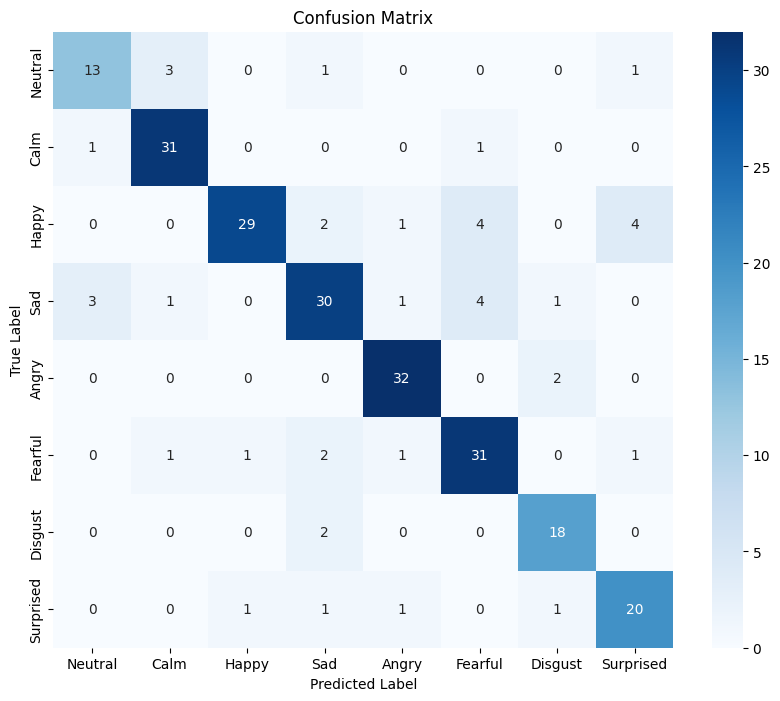


--- Classification Report ---
              precision    recall  f1-score   support

     Neutral       0.76      0.72      0.74        18
        Calm       0.86      0.94      0.90        33
       Happy       0.94      0.72      0.82        40
         Sad       0.79      0.75      0.77        40
       Angry       0.89      0.94      0.91        34
     Fearful       0.78      0.84      0.81        37
     Disgust       0.82      0.90      0.86        20
   Surprised       0.77      0.83      0.80        24

    accuracy                           0.83       246
   macro avg       0.83      0.83      0.83       246
weighted avg       0.83      0.83      0.83       246



In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# --- 1. Get Predictions ---
# The model outputs probabilities (e.g., [0.1, 0.8, 0.05...])
# We use argmax to pick the highest probability as the predicted class
y_pred_probs = model.predict(X_test_final)
y_pred = np.argmax(y_pred_probs, axis=1)

# --- 2. Define Emotion Labels (RAVDESS Order) ---
emotion_labels = ['Neutral', 'Calm', 'Happy', 'Sad', 'Angry', 'Fearful', 'Disgust', 'Surprised']

# --- 3. Generate Confusion Matrix ---
cm = confusion_matrix(y_test_final, y_pred)

# Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels,
            yticklabels=emotion_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# --- 4. Classification Report (Precision, Recall, F1-Score) ---
print("\n--- Classification Report ---")
print(classification_report(y_test_final, y_pred, target_names=emotion_labels))

In [9]:
# --- 1. Helper to Identify Gender ---
# RAVDESS: Actor ID is the last part of filename. Odd=Male, Even=Female
def is_male(file_path):
    filename = os.path.basename(file_path)
    # File format: 03-01-06-01-01-01-01.wav
    # The last part (01) is the Actor ID
    actor_id = int(filename.split("-")[-1].split(".")[0])
    return actor_id % 2 == 1  # Returns True if Odd (Male)

# --- 2. Split Test Files by Gender ---
male_files = [f for f in test_files if is_male(f)]
female_files = [f for f in test_files if not is_male(f)]

print(f"Male Test Files: {len(male_files)}")
print(f"Female Test Files: {len(female_files)}")

# --- 3. Process Subsets (Reuse your process_files function) ---
# We use augment=False because this is testing
print("\nProcessing Male Test Set...")
X_male, y_male = process_files(male_files, augment=False)
X_male = X_male[..., np.newaxis] # Add channel dimension

print("\nProcessing Female Test Set...")
X_female, y_female = process_files(female_files, augment=False)
X_female = X_female[..., np.newaxis] # Add channel dimension

# --- 4. Evaluate ---
loss_m, acc_m = model.evaluate(X_male, y_male, verbose=0)
loss_f, acc_f = model.evaluate(X_female, y_female, verbose=0)

print("\n--- Pitch Bias Analysis Results ---")
print(f"Male Accuracy:   {acc_m*100:.2f}%")
print(f"Female Accuracy: {acc_f*100:.2f}%")

bias = acc_m - acc_f
if abs(bias) > 0.05:
    print(f"⚠️ Significant Bias Detected: {bias*100:.1f}% gap!")
else:
    print("✅ Model is relatively balanced across genders.")

Male Test Files: 259
Female Test Files: 232

Processing Male Test Set...


100%|██████████| 259/259 [00:03<00:00, 73.56it/s]



Processing Female Test Set...


100%|██████████| 232/232 [00:03<00:00, 74.47it/s]



--- Pitch Bias Analysis Results ---
Male Accuracy:   79.54%
Female Accuracy: 81.47%
✅ Model is relatively balanced across genders.


In [10]:
def predict_emotion(audio_path, model):
    # 1. Load and Preprocess (EXACTLY like training)
    y, sr = librosa.load(audio_path, sr=22050)
    y_trimmed, _ = librosa.effects.trim(y, top_db=20)

    # Pad/Truncate to 3s
    max_len = 22050 * 3
    if len(y_trimmed) > max_len:
        audio_fixed = y_trimmed[:max_len]
    else:
        padding = max_len - len(y_trimmed)
        offset = padding // 2
        audio_fixed = np.pad(y_trimmed, (offset, padding - offset), 'constant')

    # Spectrogram
    S = librosa.feature.melspectrogram(y=audio_fixed, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Reshape: (1, 128, 130, 1) -> The '1' at start is the batch size
    input_data = S_dB[np.newaxis, ..., np.newaxis]

    # 2. Predict
    prediction = model.predict(input_data)
    predicted_index = np.argmax(prediction)
    confidence = np.max(prediction)

    emotion = emotion_labels[predicted_index]

    print(f"Prediction: {emotion} ({confidence*100:.1f}% Confidence)")
    return emotion

# --- Example Usage ---
# Pick a random file from test set to demonstrate
import random
random_file = random.choice(test_files)
print(f"Testing file: {random_file}")
predict_emotion(random_file, model)

Testing file: /kaggle/input/ravdess-dataset/Audio_Speech_Actors_01-24/Actor_06/03-01-01-01-02-01-06.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
Prediction: Neutral (67.3% Confidence)


'Neutral'

In [11]:
model.save('final_emotion_model.h5')